# Subsampling verschieden langer Zeitreihen

Suche der besten Subsampling-Länge

Test SVM-Klassifikation


In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn import model_selection, svm, metrics, manifold
import joblib

import prepare

2025-02-27 08:41:27.047034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 08:41:27.047064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 08:41:27.048081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 08:41:27.054184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-27 08:41:29.102930: I exter

In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER

In [3]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [4]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [5]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


Aufteilung in Trainings- und Testdaten

In [6]:
versuche_train, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)
versuche_train.shape, versuche_test.shape

((480, 5), (120, 5))

Abtrennen Zielgrößen: Label und Festigkeit

In [7]:
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values

In [8]:
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values


Bewertung Modellqualität (Regression Festigkeit)

In [9]:
def eval_model(prefix, truth, pred):
    mse = metrics.mean_squared_error(truth, pred)
    mae = metrics.mean_absolute_error(truth, pred)
    print(f"{prefix:<10} MSE: {mse:8.1f} RMSE: {np.sqrt(mse):8.1f} MAE: {mae:8.1f}")


Bewerten Testdaten mit bestem Modell

In [10]:
subsample2 = prepare.Subsample2(25)
subsample2.fit() # dummy
X_train = subsample2.transform(versuche_train.key, kurven)
X_test = subsample2.transform(versuche_test.key, kurven)


In [11]:
def class_curves(X, ax, y, field):
    color = ['black', 'blue', 'red', 'green', 'cyan']
    ti = np.arange(0, X.shape[1]) # Zeitschritte
    for i in range(X.shape[0]):
        #print(X[i,:,ax])
        plt.plot(ti, X[i,:,ax], c=color[y[i]], linewidth=0.5, alpha=0.5)
    handles = [
        matplotlib.lines.Line2D([0], [0], color='black', label='ok'),
        matplotlib.lines.Line2D([0], [0], color='blue', label='ok_wechsel'),
        matplotlib.lines.Line2D([0], [0], color='red', label='oel'),
        matplotlib.lines.Line2D([0], [0], color='green', label='leitung'),
        matplotlib.lines.Line2D([0], [0], color='cyan', label='termin'),
    ]
    plt.legend(handles=handles)

Anzeige Kurven zur Kontrolle.

Text(0.5, 1.0, 'Komplette Kurve auf 25 Zeitpunkte in gleichem Abstand approximiert')

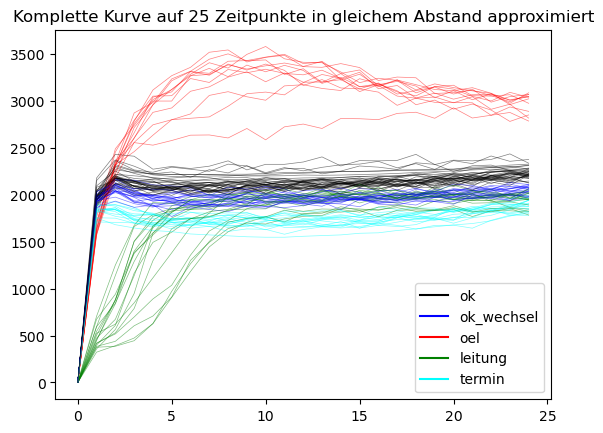

In [12]:
class_curves(X_train[:100,:,:], 0, label_train[:100], 'power')
plt.title("Komplette Kurve auf 25 Zeitpunkte in gleichem Abstand approximiert")

In [13]:
X_train_aug, y_train_aug = prepare.augment_curves(X_train, festigkeit_train)
X_train_aug.shape, y_train_aug.shape

((5280, 25, 3), (5280,))

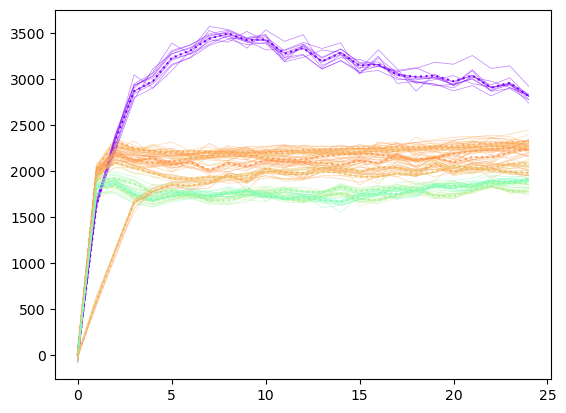

In [14]:
cmap = matplotlib.colormaps['rainbow']
max_fest = np.max(X_train[:,:,0])
norm = matplotlib.colors.Normalize(0, max_fest)
for i in range(10):
    plt.plot(np.arange(25), X_train[i,:,0], ':', c=cmap(festigkeit_train[i]/max_fest))
for i in range(11*10):
    plt.plot(np.arange(25), X_train_aug[i,:,0], c=cmap(y_train_aug[i]/max_fest), alpha=0.5, linewidth=0.5)

Kontrollanzeige t-SNE

In [15]:
tsMaxScale = prepare.TsMaxScaler()
X_train_scaled = tsMaxScale.fit_transform(X_train_aug)
X2_train = X_train_scaled[:,:,0]
X_test_scaled = tsMaxScale.transform(X_test)
X2_test = X_test_scaled[:,:,0]
X2_train.shape, X2_test.shape

((5280, 25), (120, 25))

In [16]:
X_train_projected = manifold.TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_train_scaled[:,:,0])

KeyboardInterrupt: 

In [ ]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=y_train_aug, cmap='rainbow', alpha=0.5)
plt.colorbar(label='Klasse', ticks=[0,1,2,3,4,5])
plt.title('2-D-Projektion Zeitreihe Power augmentiert (t-SNE): Festigkeit')

SVM-Regressor

In [ ]:
regr = svm.SVR(gamma=10.0, C=4714.8663634573895, epsilon=100)
_= regr.fit(X2_train, y_train_aug)

Bewertung Modell mit Testdaten

In [ ]:
y_pred_test = regr.predict(X2_test)
eval_model('Test', festigkeit_test, y_pred_test)

In [ ]:
#y_pred_test = regr.predict(X2_test)
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('svr_test.png')